In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import seaborn as sns
import difflib
from datetime import datetime
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, \
    confusion_matrix, classification_report

%matplotlib inline

pd.options.mode.chained_assignment = None 
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.float_format = '{:20,.4f}'.format
np.set_printoptions(precision=2) 

In [2]:
# Map stuff
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [63]:
def make_dates(df, year_var, mon_var, day_var):
    '''
    Creates date objects from separate month/day/year variables.
    '''
    datevar = df.apply(lambda x: str(int(x[year_var]))+'/'+str(int(x[mon_var]))+'/'+str(int(x[day_var])), axis=1)
    datevar = datevar.str.replace('-9', '1')
    datevar = datevar.apply(lambda x: datetime.strptime(x, '%Y/%m/%d'))
    datevar = datevar.dt.date

    return datevar

def coef_df(model, features = None, categories = None):
    '''
    Creates a dataframe of coefficients from a fitted model
    
    model: a fitted model from sklearn (LogisticRegression object, Lasso object, etc.)
    features: optional list of feature names. Must be in the same order as when you fit your model.
    categories: list of category names, order does not matter. Must supply if your model object contains
                multiple models (e.g. multiclass LogisticRegression). Leave empty if your model object
                contains one model (e.g. Linear Regression, binary LogisticRegression, etc.)
    '''
    if hasattr(model, 'coef_'):      
        coef_matrix = np.transpose(model.coef_)
        if categories is not None:
            columns = sorted(categories)
        else:
            columns = ['coefs']
            
    if hasattr(model, 'feature_importances_'):
        
        coef_matrix = np.transpose(model.feature_importances_)
        columns = ['importance']
    
    coef_frame = pd.DataFrame(coef_matrix, columns=columns)
    
    if features is not None:
        coef_frame['feature'] = features
        coef_frame.set_index('feature', inplace=True)
    
    return coef_frame

def coefs_sort(coefs_df, column):
    '''
    Given a coef dataframe and a column name, will sort the dataframe on abs value of that column.
    
    coefs_df: dataframe of coefficients from coef_df()
    column: name of column to sort on
    
    Returns: dataframe
    '''
    return coefs_df.loc[coefs_df[column].abs().sort_values(ascending=False).index,:]


def run_model(model, x_train, y_train, normalize=False):

    x_train = pd.get_dummies(x_train)
    features = x_train.columns
    
    if normalize:
        x_train = preprocessing.normalize(x_train, norm='max', axis=0)
    
    model.fit(x_train, y_train)
    
    score = model.score(x_train, y_train)
    coefs = coef_df(model = model, features = features, categories = y_train.unique())
    
    accs = pd.DataFrame(model.predict(x_train), columns=['yhat'])
    accs['y'] = y_train.to_frame().set_index(np.arange(len(y_train)))
    accs['correct'] = accs.apply(lambda x: x.yhat == x.y, axis=1)
    
    return score, accs, coefs

def cnf_heatmap(cnf_matrix, metric, class_labels):
    '''
    Plots heatmap of model precision or recall based on a confusion matrix.
    
    cnf_matrix: numpy array, the output of confusion_matrix()
    metric: 'precision' or 'recall'
    class_labels: labels for your classes. These will be sorted to alphabetical order to
                  match the output of confusion_matrix()
    '''
    class_labels = sorted(class_labels)
    
    if metric == 'recall':
        output_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        cmap = 'Blues'
        ylbl = 'True Label'
        xlbl = 'Predicted Label'
        title = 'Model Recall'
        
    if metric == 'precision':
        output_matrix = cnf_matrix.T.astype('float') / cnf_matrix.T.sum(axis=1)[:, np.newaxis]
        cmap = 'Oranges'
        ylbl = 'Predicted Label'
        xlbl = 'True Label'
        title = 'Model Precision'

    sns.heatmap(output_matrix, annot=True, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel(ylbl)
    plt.xlabel(xlbl)
    plt.title(title)
    


In [30]:
# Data cleaning and feature engineering

def process_disputes(df):

    # Make dates
    df['stdate'] = make_dates(df, 'styear', 'stmon', 'stday')
    df['enddate'] = make_dates(df, 'endyear', 'endmon', 'endday')
    
    return df

def process_incids(df):
    
    # Make dates
    df['stdate'] = make_dates(df, 'styear', 'stmon', 'stday')
    df['enddate'] = make_dates(df, 'endyear', 'endmon', 'endday')

    # Sort
    df.sort_values(['dispnum3', 'stdate'], inplace=True)
    
    # Feature engineering
    df['date_diff'] = df.groupby('dispnum3').stdate.diff()
    
    df['interval'] = df.loc[~pd.isnull(df.date_diff), 'date_diff'].apply(lambda x: x.days)
    df['next_interval'] = df.groupby('dispnum3').shift(-1).interval
    
    df['disp_len'] = df.groupby('dispnum3').stdate.apply(lambda x: x-x.min())
    df.disp_len = df.disp_len.apply(lambda x: x.days)

    df['next_hostlev'] = df.groupby('dispnum3').hostlev.shift(-1)
    df['next_mo_hostlev'] = np.where(df.next_interval <= 30, df.next_hostlev, np.nan)
    df['prev_hostlev'] = df.groupby('dispnum3').hostlev.shift() 
    df.prev_hostlev.fillna(0, inplace=True)  # Fill 0 for prev_hostlev of new dispute
    df['max_hostlev'] = df.groupby('dispnum3').hostlev.cummax()
    
    roll_hostlev = df.groupby('dispnum3').rolling(window = 5, min_periods=0).hostlev.mean().reset_index()
    roll_hostlev.set_index('level_1', inplace=True)
    df['roll_hostlev'] = roll_hostlev.hostlev
    
    df['n_prior_inc'] = df.groupby('dispnum3').incidnum3.rank(ascending=1, method='first')-1

    df['incids_per_day'] = np.where(df.disp_len == 0, 0, df.n_prior_inc/df.disp_len)
    
    df['hostlev_ch'] = np.where(df.next_mo_hostlev > df.hostlev, 'esc',
                               np.where(df.next_mo_hostlev == df.hostlev, 'no_change',
                                       np.where(df.next_mo_hostlev < df.hostlev, 'de_esc',
                                               'no_incid')))
    df = df.loc[~((df.hostlev == 5) & (df.hostlev_ch == 'no_incid'))] # Delete last row of war because war is ongoing

    df.loc[:, ['prev_hostlev', 'fatality', 'action']] = df[['prev_hostlev', 'fatality', 'action']]. \
                        apply(lambda x: x.astype(int).astype(str)) 
    
    # I'm leaving -9's in the duration and fatality columns.
    # -9 in fatality may indicate a special category for which fatalities are unknown
    
    return df
    

In [4]:
# Load disputes
disputes_all = pd.read_csv('MIDA_4.01.csv')
disputes_all.columns = disputes_all.columns.map(lambda x: x.lower())

# Load states involved in each dispute 
disputes_p_all = pd.read_csv('MIDB_4.01.csv')
disputes_p_all.columns = disputes_p_all.columns.map(lambda x: x.lower())

# Load incidents
incids_all = pd.read_csv('MIDI_4.01.csv')
incids_all.columns = incids_all.columns.map(lambda x: x.lower())

In [29]:
# Create train split

disputes, disputes_test = train_test_split(disputes_all, train_size=.7, 
                                     stratify = disputes_all.hostlev, random_state=42)

incids = incids_all[incids_all.dispnum3.isin(disputes.dispnum3)]

disputes_p = disputes_p_all[disputes_p_all.dispnum3.isin(incids.dispnum3)]

In [31]:
incids = process_incids(incids)
disputes = process_disputes(disputes)

In [45]:
incids_test_data = incids_all[incids_all.dispnum3.isin(disputes_test.dispnum3)]
incids_test_data = process_incids(incids_test_data)

In [168]:
# Class balance in train and test sets:

print incids.hostlev_ch.value_counts(normalize=True), '\n'
print incids_test_data.hostlev_ch.value_counts(normalize=True)

no_change                 0.4704
no_incid                  0.3318
de_esc                    0.1012
esc                       0.0966
Name: hostlev_ch, dtype: float64 

no_incid                  0.4597
no_change                 0.3629
de_esc                    0.0941
esc                       0.0833
Name: hostlev_ch, dtype: float64


In [172]:
# Logistic Model, seems to do okay with rare classes

logis2_x = incids[['max_hostlev','roll_hostlev','disp_len','interval','prev_hostlev','numa',  
                 'n_prior_inc','fatality','action', 'incids_per_day']]

logis2_x.interval.fillna(-9, inplace=True)
logis2_x['fatality_6'] = 0                   # Insert missing dummy variable
logis2_y = incids.hostlev_ch
logis2 = LogisticRegressionCV(class_weight='balanced')

logis2_score, logis2_accs, logis2_coefs = run_model(logis2, logis2_x, logis2_y, normalize=True)

In [176]:
print 'Train Accuracy:', logis2_score, '\n'
coefs_sort(logis2_coefs, 'no_change')

Train Accuracy: 0.538551401869 



,de_esc,esc,no_change,no_incid
feature,,,,
max_hostlev,0.0017,0.0002,-5.8395,-0.8352
action_20,-0.0000,-0.0000,4.8102,-0.0568
action_3,-0.0002,0.0003,-4.6247,-0.0168
incids_per_day,-0.0004,-0.0003,3.7355,-0.6457
prev_hostlev_5,-0.0000,-0.0000,2.8340,-0.0656
action_21,-0.0000,-0.0000,2.4007,-0.0367
interval,-0.0002,-0.0002,-2.2623,2.2918
fatality_3,-0.0001,-0.0001,2.0723,-0.0086
roll_hostlev,0.0015,-0.0027,1.5572,0.7642


In [174]:
# Show Recall and errors made
logis2_accs.sort_values(['y', 'yhat']).groupby(['y', 'yhat']).correct.size().groupby(level=0). \
    transform(lambda x: x/x.sum())

y          yhat     
de_esc     de_esc                    0.3192
           esc                       0.0731
           no_change                 0.2962
           no_incid                  0.3115
esc        esc                       0.4073
           no_change                 0.3508
           no_incid                  0.2419
no_change  de_esc                    0.0414
           esc                       0.1300
           no_change                 0.5588
           no_incid                  0.2699
no_incid   de_esc                    0.0364
           esc                       0.0998
           no_change                 0.2488
           no_incid                  0.6150
dtype: float64

In [171]:
# Show Precision and errors made
logis2_accs.sort_values(['yhat', 'y']).groupby(['yhat', 'y']).correct.size().groupby(level=0). \
    transform(lambda x: x/x.sum())


yhat       y        
de_esc     de_esc                    0.5061
           no_change                 0.3049
           no_incid                  0.1890
esc        de_esc                    0.0525
           esc                       0.2790
           no_change                 0.4337
           no_incid                  0.2348
no_change  de_esc                    0.0733
           esc                       0.0828
           no_change                 0.6422
           no_incid                  0.2017
no_incid   de_esc                    0.0817
           esc                       0.0605
           no_change                 0.3290
           no_incid                  0.5288
dtype: float64

In [175]:
print classification_report(logis2_y,
                    logis2.predict(preprocessing.normalize(pd.get_dummies(logis2_x), norm='max',axis=0)))

             precision    recall  f1-score   support

     de_esc       0.51      0.32      0.39       260
        esc       0.28      0.41      0.33       248
  no_change       0.64      0.56      0.60      1208
   no_incid       0.53      0.62      0.57       852

avg / total       0.56      0.54      0.54      2568



In [190]:
# Use Logistic model to make predictions on test data

logis2_x_test = incids_test_data[['max_hostlev','roll_hostlev','disp_len','interval','prev_hostlev','numa',  
                 'n_prior_inc','fatality','action', 'incids_per_day']]

logis2_x_test.interval.fillna(-9, inplace=True)
logis2_x_test['fatality_4'] = 0
logis2_x_test['action_13'] = 0
logis2_x_test['action_20'] = 0

logis2_x_test_normed = preprocessing.normalize(pd.get_dummies(logis2_x_test), norm='max', axis=0)
logis2_y_test = incids_test_data.hostlev_ch

print 'Test accuracy:', accuracy_score(logis2_y_test, logis2.predict(logis2_x_test_normed)), '\n'
print classification_report(logis2_y_test, logis2.predict(logis2_x_test_normed))

Test accuracy: 0.458333333333 

             precision    recall  f1-score   support

     de_esc       0.20      0.04      0.07        70
        esc       0.00      0.00      0.00        62
  no_change       0.41      0.91      0.57       270
   no_incid       0.73      0.27      0.39       342

avg / total       0.50      0.46      0.39       744



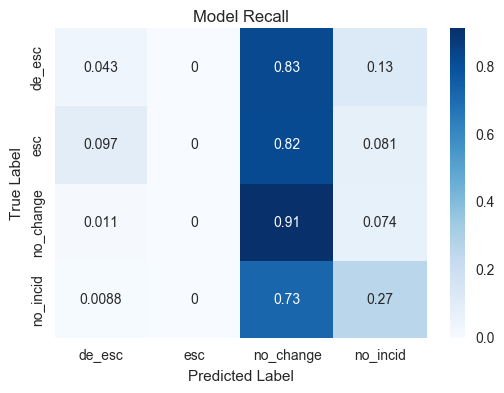

In [193]:
# Visualize Recall and Precision by class

cnf_matrix = confusion_matrix(logis2_y_test, logis2.predict(logis2_x_test_normed))
cnf_heatmap(cnf_matrix, metric='recall', class_labels=logis2_y_test.unique())

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in divide


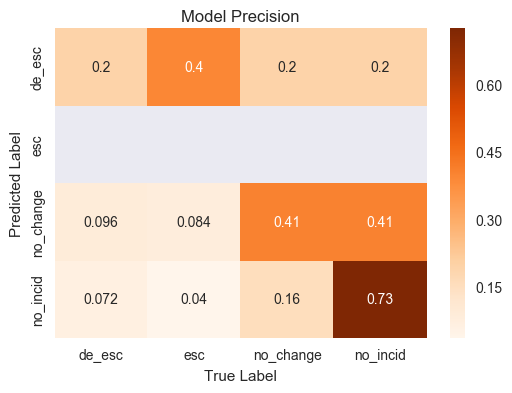

In [192]:
cnf_heatmap(cnf_matrix, metric='precision', class_labels=logis2_y_test.unique())
# Gives warning because 'esc' class was never predicted

In [177]:
# Random Forest, same features as Logistic, does poorly with rare classes

for_forest1 = incids[['max_hostlev','roll_hostlev','disp_len','interval','prev_hostlev','numa',  
                 'n_prior_inc','fatality','action', 'incids_per_day']]

for_forest1.interval.fillna(-9, inplace=True)

forest1_x_train, forest1_x_test, forest1_y_train, forest1_y_test = \
                train_test_split(for_forest1, incids.hostlev_ch, test_size=.25, random_state=43, \
                                 stratify=incids.hostlev_ch)
forest1_x_train['fatality_6'] = 0  # Add missing dummy variable

    
forest1_x_test = pd.get_dummies(forest1_x_test, drop_first=False)
forest1_x_test['action_20'] = 0
forest1_x_test['action_21'] = 0
forest1_x_test['prev_hostlev_5'] = 0
forest1_x_test['fatality_3'] = 0
forest1_x_test['fatality_6'] = 0

forest1 = RandomForestClassifier(n_estimators = 200, oob_score=True, random_state=123, class_weight='balanced')

_, _, forest1_coefs = run_model(forest1, forest1_x_train, forest1_y_train, normalize=False)

forest1_accs = pd.DataFrame(forest1.predict(forest1_x_test), columns=['yhat'])
forest1_accs['y'] = forest1_y_test.to_frame().set_index(np.arange(len(forest1_y_test)))
forest1_accs['correct'] = forest1_accs.apply(lambda x: x.yhat == x.y, axis=1)

In [178]:
# View accuracy and precision/recall on preliminary test data

print 'Out of Bag score:', forest1.oob_score_, '\n'
print 'Test accuracy:', accuracy_score(forest1.predict(forest1_x_test), forest1_y_test), '\n'
print coefs_sort(forest1_coefs, 'importance'), '\n'
print classification_report(forest1.predict(forest1_x_test), forest1_y_test)

Out of Bag score: 0.544652128764 

Test accuracy: 0.518691588785 

                         importance
feature                            
incids_per_day               0.1641
disp_len                     0.1570
n_prior_inc                  0.1502
interval                     0.1356
roll_hostlev                 0.0895
action_16                    0.0520
action_17                    0.0253
action_1                     0.0237
action_12                    0.0213
action_7                     0.0189
prev_hostlev_3               0.0183
prev_hostlev_4               0.0164
max_hostlev                  0.0158
fatality_0                   0.0151
numa                         0.0150
action_15                    0.0130
action_11                    0.0121
fatality_-9                  0.0106
prev_hostlev_2               0.0095
action_8                     0.0095
fatality_1                   0.0064
prev_hostlev_0               0.0053
action_14                    0.0050
action_10                    0.00

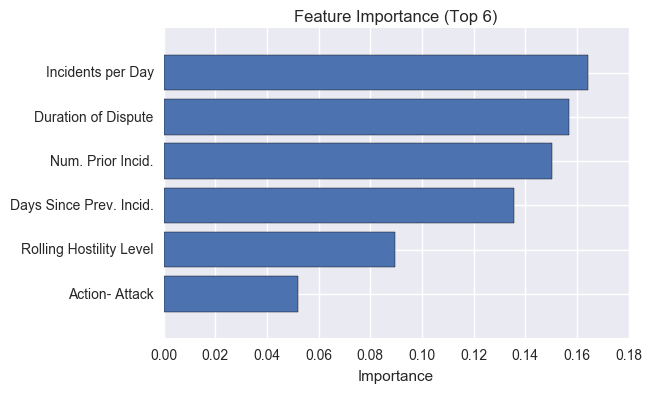

In [216]:
# Visualize top 6 important features

features = ['Action- Attack', 'Rolling Hostility Level', 'Days Since Prev. Incid.', 'Num. Prior Incid.', 
           'Duration of Dispute', 'Incidents per Day']
y_pos = np.arange(len(features))
importance = forest1_coefs.importance.sort_values()[-6:]
 
plt.barh(y_pos, importance, align='center')
plt.yticks(y_pos, features)
plt.xlabel('Importance')
plt.title('Feature Importance (Top 6)');
 

In [185]:
# Use Random Forest model to make predictions on test data

forest1_x_test2 = pd.get_dummies(logis2_x_test)   # Use same test data as the Logistic model

forest1_y_test2 = logis2_y_test

print 'Final test accuracy:', accuracy_score(forest1_y_test2, forest1.predict(forest1_x_test2)), '\n'
print classification_report(forest1_y_test2, forest1.predict(forest1_x_test2))

Final test accuracy: 0.557795698925 

             precision    recall  f1-score   support

     de_esc       0.32      0.09      0.13        70
        esc       0.00      0.00      0.00        62
  no_change       0.50      0.66      0.57       270
   no_incid       0.63      0.68      0.65       342

avg / total       0.50      0.56      0.52       744



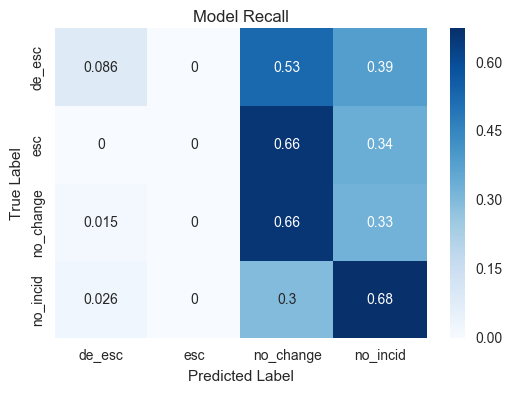

In [189]:
# Visualize Recall and Precision by class
cnf_matrix4 = confusion_matrix(forest1_y_test2, forest1.predict(forest1_x_test2))
cnf_heatmap(cnf_matrix4, 'recall', forest1_y_test2.unique())

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:92: RuntimeWarning: invalid value encountered in divide


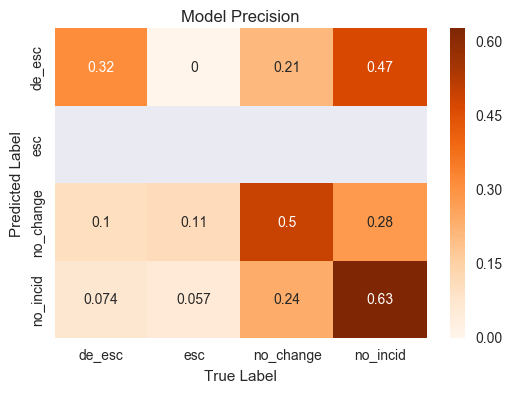

In [187]:
cnf_heatmap(cnf_matrix4, 'precision', forest1_y_test2.unique())
# Gives warning because 'esc' class was never predicted

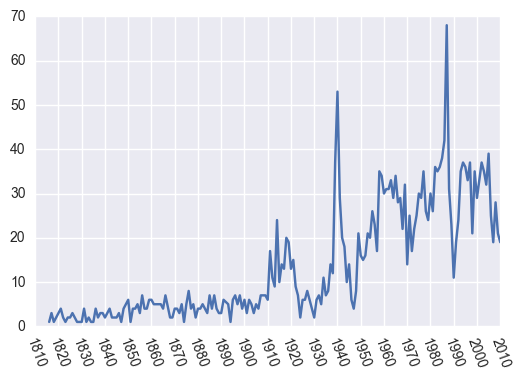

In [215]:
# Some data viz and interesting numbers

# How many disputes per year?
annual_disputes = disputes_all.sort_values('styear').groupby('styear').size().reset_index()
annual_disputes.columns = ['styear', 'n']

plt.plot(annual_disputes.styear, annual_disputes.n)
plt.xlim(1810, 2010)
plt.xticks(np.arange(1810, 2011, 10), range(1810, 2011, 10), rotation=-70);

In [109]:
# Who has the US disputed with since 1992?

disputes_p.groupby(['dispnum3', 'sidea']).filter(lambda x: np.any(x.statenme == 'United States of America')).\
    groupby('statenme').size().sort_values(ascending=False)[1:]

US_dispnums = disputes_p.loc[disputes_p.statenme == 'United States of America', 'dispnum3']
temp = disputes_p.groupby(['dispnum3', 'sidea']).filter(lambda x: np.all(x.statenme != 'United States of America'))

US_enemies = temp[temp.dispnum3.isin(US_dispnums)]
US_enemies.groupby('statenme').size().sort_values(ascending=0)

statenme
North Korea    7
Iran           7
Iraq           6
Yugoslavia     5
China          5
Pakistan       4
Venezuela      2
Syria          2
Russia         2
Sudan          1
Somalia        1
Liberia        1
Ivory Coast    1
Haiti          1
Canada         1
Afghanistan    1
dtype: int64

In [126]:
# Read in country codes and country lat/lon for visualization

countries = pd.read_csv('countries.csv')
countries.drop('country', axis=1, inplace=True)

country_codes = pd.read_csv('COW country codes.csv')
country_codes.columns = country_codes.columns.map(lambda x: x.lower())
country_codes.drop_duplicates(inplace=True)

In [107]:
disputes_p = disputes_p.merge(country_codes.drop('ccode', axis=1), how='left', left_on='stabb', right_on='stateabb').\
            drop('stateabb', axis=1).sort_values('styear')

In [131]:
# Get country names from country_codes to merge on
disputes_p_plot = disputes_p[~pd.isnull(disputes_p.statenme)]

disputes_p_plot['merge_name'] = disputes_p_plot.statenme.apply(
                lambda x: difflib.get_close_matches(x, countries.name, n=1, cutoff=.3))
disputes_p_plot.merge_name = disputes_p_plot.merge_name.apply(lambda x: x[0])

# Fix countries that matched to the wrong name
disputes_p_plot.loc[disputes_p_plot.statenme == 'Yugoslavia', 'merge_name'] = 'Serbia'
disputes_p_plot.loc[disputes_p_plot.statenme == 'Democratic Republic of the Congo', 'merge_name'] = 'Congo [DRC]'
disputes_p_plot.loc[disputes_p_plot.statenme == 'Ivory Coast', 'merge_name'] = "Côte d'Ivoire"
disputes_p_plot.loc[disputes_p_plot.statenme == 'Congo', 'merge_name'] = 'Congo [Republic]'
disputes_p_plot.loc[disputes_p_plot.statenme == 'Yugoslavia', 'merge_name'] = 'Serbia'

# Merge lat/lon into disputes
disputes_p_plot = disputes_p_plot.merge(countries, how='left', left_on='merge_name', right_on='name')


In [133]:
# Get num disputes per country (data is only from 1992 forward)
disp_by_state = disputes_p_plot.groupby(['merge_name', 'latitude', 'longitude']).size().reset_index()
disp_by_state.columns = ['merge_name', 'latitude', 'longitude', 'n']

In [136]:
disp_by_state.sort_values('n', ascending=False)

,merge_name,latitude,longitude,n
129,United States,37.0902,-95.7129,47
100,Russia,61.5240,105.3188,39
24,China,35.8617,104.1954,38
58,Iran,32.4279,53.6880,30
63,Japan,36.2048,138.2529,29
124,Turkey,38.9637,35.2433,27
59,Iraq,33.2232,43.6793,24
89,North Korea,40.3399,127.5101,20
113,Sudan,12.8628,30.2176,18
104,Serbia,44.0165,21.0059,16


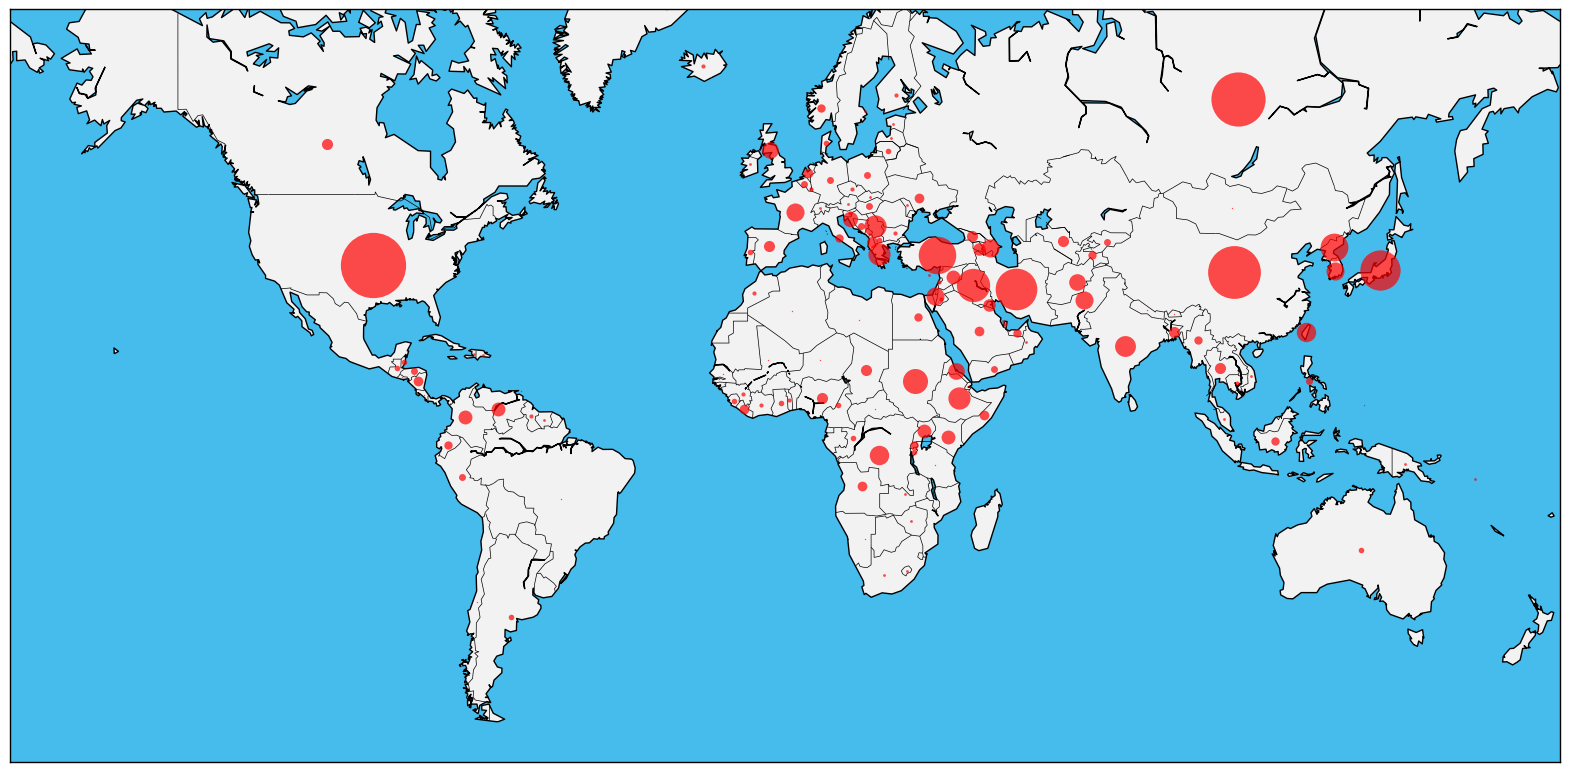

In [159]:
# How many disputes per country, since 1992 (the time period I'm modeling on)?

fig, ax = plt.subplots(figsize=(20,26))

m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180)


m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.drawcountries() 

disp_by_state.apply(lambda x: m.plot(x['longitude'], x['latitude'], color='red', marker='o', markersize=x['n'], latlon=True, alpha=.7), axis=1);
